<div class="alert alert-block alert-warning">

## Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.

## Определить, с каких источников и в какое время суток чаще всего заходят роботы.

</div>

In [269]:
import pandas as pd
from pprint import pprint
import requests
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# собираем данные

token = 'y0_AgAAAABIpJWFAAiafwAAAADTu9PVKxUUFvICQnOLEfrhXMi1hgsRnkU'

headers = {'Authorization': 'OAuth ' + token}

params = {'metrics': 'ym:s:users', 
          'dimensions': 'ym:s:isRobot,ym:s:hour,ym:s:lastsignTrafficSource',
          'date1': '2020-09-01',  
          'date2': '2020-09-30',     
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}

response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)

print (response.status_code) # смотрим ответ от сервера
metrika_data = response.json()
print(metrika_data['total_rows']) # смотрим количество строк данных
pprint(metrika_data['data'][10:13]) # смотрим для примера 3 строки данных

200
182
[{'dimensions': [{'id': 'no', 'name': 'People'},
                 {'id': '19', 'name': '19:00'},
                 {'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'}],
  'metrics': [119.0]},
 {'dimensions': [{'id': 'no', 'name': 'People'},
                 {'id': '22', 'name': '22:00'},
                 {'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'}],
  'metrics': [115.0]},
 {'dimensions': [{'id': 'no', 'name': 'People'},
                 {'id': '18', 'name': '18:00'},
                 {'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'}],
  'metrics': [110.0]}]


In [270]:
# поработаю на структурой файла metrika_data
for i in metrika_data['data']:
    i['type_user'] = i['dimensions'][0]['name']
    i['time'] = i['dimensions'][1]['name']
    i['source'] = i['dimensions'][2]['name']
    i['metrics_users'] = i['metrics'][0] # уникальные посетители
    i.pop('dimensions') # удаляем лишние ключи
    i.pop('metrics') # удаляем лишние ключи
    
metrika_data['data'][0:3] # посмотрим на результат
    
    

[{'type_user': 'People',
  'time': '16:00',
  'source': 'Search engine traffic',
  'metrics_users': 184.0},
 {'type_user': 'People',
  'time': '15:00',
  'source': 'Search engine traffic',
  'metrics_users': 174.0},
 {'type_user': 'People',
  'time': '11:00',
  'source': 'Search engine traffic',
  'metrics_users': 166.0}]

In [271]:
# преобразуем в датафрейм пандас
metrika_data_df = pd.DataFrame(metrika_data['data'])
metrika_data_df = metrika_data_df.sort_values(by = ['time','source'])
metrika_data_df

,type_user,time,source,metrics_users
81,People,00:00,Direct traffic,7.0
131,Robots,00:00,Direct traffic,2.0
104,People,00:00,Link traffic,3.0
15,People,00:00,Search engine traffic,83.0
55,Robots,00:00,Search engine traffic,17.0
...,...,...,...,...
161,People,23:00,Link traffic,1.0
181,Robots,23:00,Link traffic,1.0
13,People,23:00,Search engine traffic,99.0
51,Robots,23:00,Search engine traffic,21.0


In [272]:
df = metrika_data_df.groupby('type_user', as_index=False)['metrics_users'].sum() 
df['traffic_share_percent'] = round(100 * df['metrics_users']/ df['metrics_users'].sum(), 2)
df

,type_user,metrics_users,traffic_share_percent
0,People,3184.0,77.32
1,Robots,934.0,22.68


Ответ к задаче 1: 22.68% - доля роботов от общего трафика

### Задача 2
### Определить, с каких источников и в какое время суток чаще всего заходят роботы.

In [273]:
# делаем сводную таблицу
pivot = metrika_data_df[metrika_data_df['type_user'] == 'Robots'].pivot_table(
    columns = 'time',
    index = 'source',
    values = 'metrics_users',
    aggfunc= 'sum'
)
pivot

time,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
source,,,,,,,,,,,,,,,,,,,,,
Cached page traffic,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Direct traffic,2.0,4.0,2.0,2.0,3.0,3.0,3.0,5.0,5.0,9.0,...,13.0,6.0,8.0,9.0,8.0,10.0,8.0,12.0,6.0,8.0
Internal traffic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Link traffic,NaN,NaN,NaN,1.0,NaN,NaN,2.0,1.0,1.0,1.0,...,2.0,1.0,3.0,2.0,1.0,NaN,2.0,NaN,1.0,1.0
Search engine traffic,17.0,8.0,5.0,3.0,3.0,1.0,3.0,6.0,25.0,28.0,...,57.0,63.0,62.0,55.0,31.0,38.0,26.0,28.0,30.0,21.0
Social network traffic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,3.0,NaN


строим тепловую карту для решения задачи №2

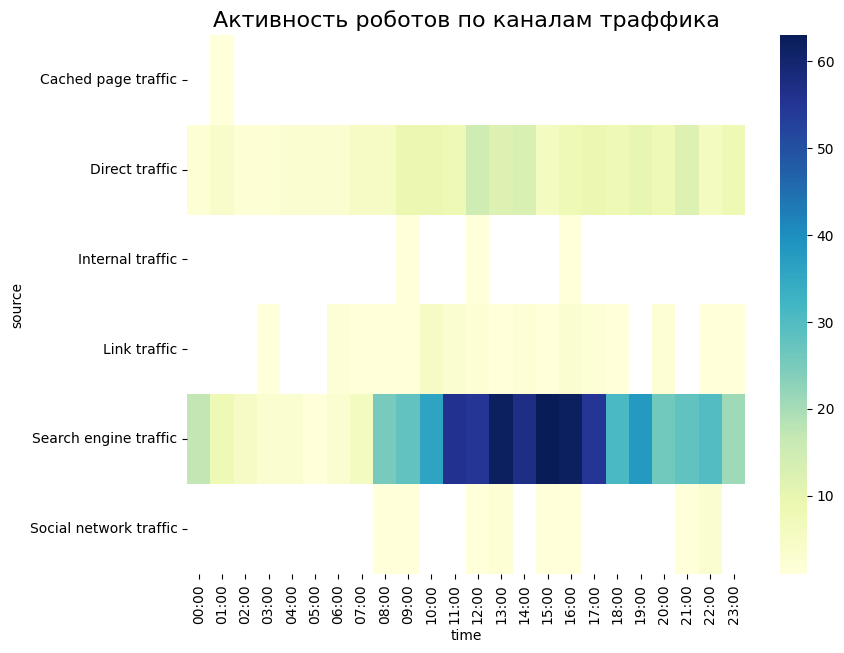

In [274]:
fig = plt.figure(figsize=(9, 7))
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Активность роботов по каналам траффика', fontsize=16);

Ответ к задаче №2: чаще всего боты заходят с канала Search engine traffic с 11 до 5 часов дня. Но здесь я считал уникальных пользователей-роботов, посмотрим, что по визитам.

In [275]:
params = {'metrics': 'ym:s:visits', 
          'dimensions': 'ym:s:isRobot,ym:s:hour,ym:s:lastsignTrafficSource',
          'date1': '2020-09-01',  
          'date2': '2020-09-30',     
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}

response1 = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)

print (response1.status_code) # смотрим ответ от сервера
metrika_data1 = response1.json()
print(metrika_data1['total_rows']) # смотрим количество строк данных
pprint(metrika_data1['data'][10:13]) # смотрим для примера 3 строки данных

200
182
[{'dimensions': [{'id': 'no', 'name': 'People'},
                 {'id': '19', 'name': '19:00'},
                 {'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'}],
  'metrics': [123.0]},
 {'dimensions': [{'id': 'no', 'name': 'People'},
                 {'id': '22', 'name': '22:00'},
                 {'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'}],
  'metrics': [119.0]},
 {'dimensions': [{'id': 'no', 'name': 'People'},
                 {'id': '18', 'name': '18:00'},
                 {'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'}],
  'metrics': [112.0]}]


In [276]:
# поработаю на структурой файла metrika_data
for i in metrika_data1['data']:
    i['type_user'] = i['dimensions'][0]['name']
    i['time'] = i['dimensions'][1]['name']
    i['source'] = i['dimensions'][2]['name']
    i['metrics_visits'] = i['metrics'][0] # уникальные посетители
    i.pop('dimensions') # удаляем лишние ключи
    i.pop('metrics') # удаляем лишние ключи
    
metrika_data1['data'][0:3] # посмотрим на результат

[{'type_user': 'People',
  'time': '16:00',
  'source': 'Search engine traffic',
  'metrics_visits': 189.0},
 {'type_user': 'People',
  'time': '15:00',
  'source': 'Search engine traffic',
  'metrics_visits': 177.0},
 {'type_user': 'People',
  'time': '11:00',
  'source': 'Search engine traffic',
  'metrics_visits': 169.0}]

In [277]:
# преобразуем в датафрейм пандас
metrika_data_df1 = pd.DataFrame(metrika_data1['data'])
metrika_data_df1 = metrika_data_df1.sort_values(by = ['time','source'])
metrika_data_df1

,type_user,time,source,metrics_visits
73,People,00:00,Direct traffic,8.0
132,Robots,00:00,Direct traffic,2.0
104,People,00:00,Link traffic,3.0
16,People,00:00,Search engine traffic,85.0
55,Robots,00:00,Search engine traffic,17.0
...,...,...,...,...
161,People,23:00,Link traffic,1.0
181,Robots,23:00,Link traffic,1.0
14,People,23:00,Search engine traffic,104.0
51,Robots,23:00,Search engine traffic,21.0


In [278]:
df1 = metrika_data_df1.groupby('type_user', as_index=False)['metrics_visits'].sum()
display(df1, df) # сравниваем визиты и уникальных роботов

,type_user,metrics_visits
0,People,3353.0
1,Robots,962.0


,type_user,metrics_users,traffic_share_percent
0,People,3184.0,77.32
1,Robots,934.0,22.68


In [279]:
# делаем сводную таблицу
pivot1 = metrika_data_df1[metrika_data_df1['type_user'] == 'Robots'].pivot_table(
    columns = 'time',
    index = 'source',
    values = 'metrics_visits',
    aggfunc= 'sum'
)
pivot1

time,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
source,,,,,,,,,,,,,,,,,,,,,
Cached page traffic,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Direct traffic,2.0,4.0,2.0,2.0,3.0,3.0,3.0,5.0,5.0,12.0,...,14.0,6.0,8.0,9.0,9.0,10.0,8.0,13.0,6.0,8.0
Internal traffic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Link traffic,NaN,NaN,NaN,1.0,NaN,NaN,2.0,1.0,1.0,1.0,...,2.0,1.0,3.0,2.0,1.0,NaN,2.0,NaN,1.0,1.0
Search engine traffic,17.0,8.0,5.0,3.0,3.0,1.0,3.0,6.0,29.0,36.0,...,58.0,63.0,62.0,55.0,31.0,38.0,26.0,29.0,30.0,21.0
Social network traffic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,3.0,NaN


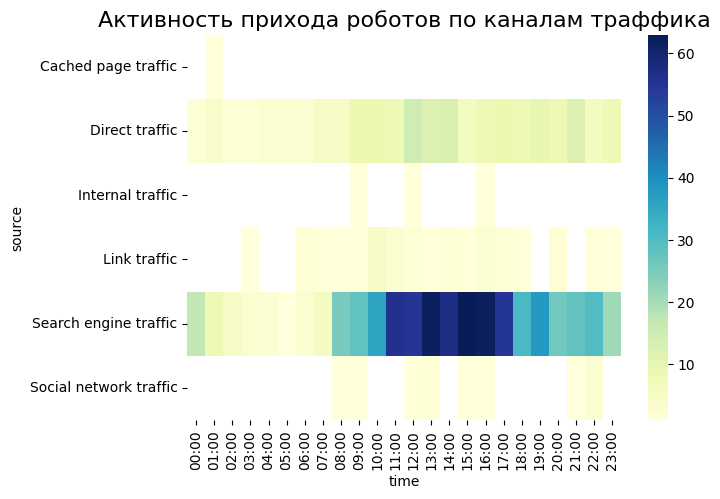

In [282]:
# активность уникальных роботов-посетителей
fig = plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Активность прихода роботов по каналам траффика', fontsize=16);

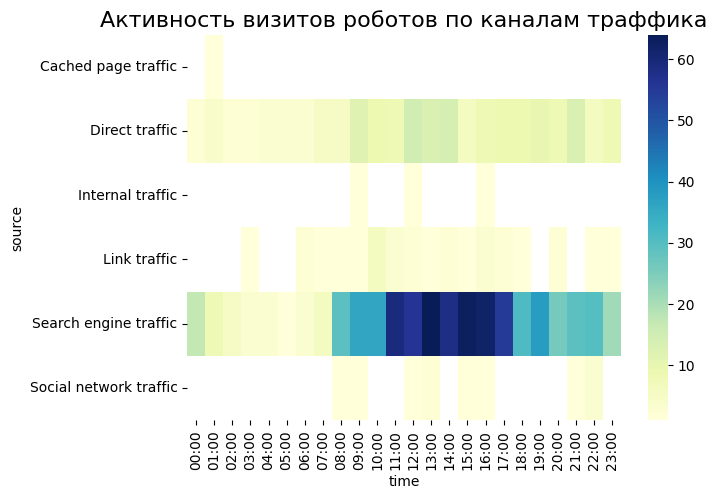

In [283]:
# активность роботов по визитам
fig = plt.figure(figsize=(7, 5))

heatmap1 = sns.heatmap(data=pivot1, cmap='YlGnBu')
heatmap1.set_title('Активность визитов роботов по каналам траффика', fontsize=16);

результаты, примерно, одинаковые.